Streaming Data Management and Time Series Analysis project

Riva Leonardo, 830647

# Libraries

In [106]:
!pip install statsmodels -U

In [107]:
# general
import pandas as pd
import numpy as np
import statsmodels
import holidays
import warnings
warnings.filterwarnings("ignore")

# statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.structural import UnobservedComponents
from scipy.stats import linregress

# machine learning
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, ReLU, CuDNNGRU, CuDNNLSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.callbacks import LambdaCallback, ModelCheckpoint
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.model_selection import train_test_split

# graphics
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (23,6)
import seaborn as sns
sns.set_style('darkgrid', {"axes.facecolor": "0.94"})
sns.set_color_codes(palette='pastel')

# drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [108]:
path = '/content/drive/MyDrive/Università/5/Streaming data mng & time series analysis/Progetto/'

# Import file

In [109]:
df = pd.read_csv(path+'Project_data_2021_2022 (TRAINSET).csv')

In [110]:
df['Hour'] = df['Hour'].astype(str).apply(lambda x: x.zfill(2))
df['datetime'] = df['Date'] + ' ' + df['Hour']
df.drop(columns=['Date', 'Hour'], inplace=True)

In [111]:
df.columns = [x.lower() for x in df.columns]
df['datetime'] = pd.to_datetime(df.datetime, format='%Y-%m-%d %H')
df = df.set_index('datetime')
df.index = pd.DatetimeIndex(df.index.values, freq='h')

# Functions

In [112]:
def boxplot_distribution(df, x, y):
  ax = df.boxplot(by=x, column=y)
  plt.title('')
  plt.suptitle('')
  ax.set_title('');
  ax.set_xlabel(' ');
  ax.set_ylabel(' ');
  ax = plt.show()

In [113]:
def plot_acf_pacf(y, lags):
  fig, ax = plt.subplots(1, 2, figsize=(20,6))
  plot_acf(y, lags=lags, ax=ax[0], alpha=.05, zero=False, auto_ylims=True)
  plot_pacf(y, lags=lags, ax=ax[1], alpha=.05, zero=False, auto_ylims=True)
  plt.show()

In [114]:
def get_exog_sinusoids(n, period, df_train, df_test):
  omega = 2 * np.pi / period

  sinusoids = pd.DataFrame()

  for i in range(1, n+1):
    sinusoids['sin' + str(i)] = [np.sin(omega * i * x) for x in np.arange(len(df_train)+len(df_test))] 
    sinusoids['cos' + str(i)] = [np.cos(omega * i * x) for x in np.arange(len(df_train)+len(df_test))] 

  sinusoids.index = np.concatenate([df_train.index, df_test.index], axis=None)
  sinusoids.index = pd.DatetimeIndex(sinusoids.index.values, freq='h')

  sinusoids_train = sinusoids.iloc[:len(df_train)]
  sinusoids_test = sinusoids.iloc[len(df_train):]

  return sinusoids_train, sinusoids_test
  return sinusoids.index

In [115]:
def get_exog_dummies(df_train, df_test):
  hol = pd.DataFrame(data=['pasqua04', 'pasquetta04', 'festa_liberazione', 'festa_repubblica', 'antivigilia_natale',
                           'vigilia_natale', 'natale', 'epifania', 'pasqua05', 'pasquetta05'], 
                   index=['2004-04-11', '2004-04-12', '2004-04-25', '2004-06-01', '2004-12-23', 
                          '2004-12-24', '2004-12-25', '2005-01-05', '2005-03-27', '2005-03-28'])
  hol.index = pd.to_datetime(hol.index)
  hol_train = hol['2004-03-01':'2005-01-31']
  hol_test = hol['2005-02-01':'2005-02-28']

  tmp = pd.concat((df_train, hol_train), axis=1)
  exog_train = pd.get_dummies(tmp)
  del exog_train['co']

  tmp = pd.concat((df_val, hol_test), axis=1)
  exog_test = pd.get_dummies(tmp)
  del exog_test['co']
  for c in list(exog_train.columns):
    exog_test[c] = [0] * len(exog_test)

  return exog_train.copy(), exog_test.copy()

In [116]:
def predict(mod, start, end, exog_var=None, _log=True):
  if exog_var is None:
    pred = mod.get_prediction(start=start, end=end).predicted_mean
  else:
    pred = mod.get_prediction(start=start, end=end, exog=exog_var).predicted_mean

  if _log:
    pred = np.exp(pred)

  return pred

In [117]:
def knn_forecasting(series, h, p, k, operation='mean'):
  t = len(series)
  query = np.array(series[(t-p):t])
  idx_start = [-1] * k
  count = 0
  used_idxs = []

  while count < k:
    min_dist = np.inf

    for i in range(1, t-p-h): # -h avoids using current values for prediction
      subseq = np.array(series[i:(i+p)])
      dist = np.linalg.norm(subseq - query) # euclidean distance

      if dist < min_dist and i not in used_idxs:
        min_dist = dist
        idx_start[count] = i

    # a subsequence has been found -> don't consider it anymore
    used_idxs += list(range(idx_start[count], idx_start[count]+p))

    count += 1

  futures = [series[(i+1):(i+h+1)] for i in idx_start]

  if operation == 'mean':
    future = np.mean(futures, axis=0)
  elif operation == 'median':
    future = np.median(futures, axis=0)
  elif operation == 'weighted_mean':
    future = np.average(futures, weights=np.arange(len(futures))[::-1], axis=0)
  else:
    print('ERROR!')
    return None

  return future.flatten()

In [118]:
def plot_prediction(groundtruth, prediction):
  plt.plot(groundtruth, label='True')
  plt.plot(prediction, label='Predicted')
  plt.legend(loc="upper right")
  plt.show()

In [119]:
def create_rrn_data(data, window, output=1):
  x = []
  y = []
  for i in range(len(data) - window - output):
    ts0 = data[i:(i+window)]
    ts1 = data[(i+window):(i+window+output)]
    x.append(ts0)
    y.append(ts1)
  return np.array(x), np.array(y)

In [120]:
def rnn_predict(model, h, current_batch, output=1):
  scaled_predictions = []
  for i in range(int(h/output)):
    pred = model.predict(current_batch)
    scaled_predictions += list(pred[0])
    current_batch = np.append(current_batch[:,output:,:], [np.array(pred[0]).reshape(-1,1)], axis=1) # updates batch with new prediction, deleting oldest values
  return scaler.inverse_transform(np.array([scaled_predictions])).flatten()

# Exploration

In [29]:
df.head()

,co
2004-03-10 18:00:00,1360.0
2004-03-10 19:00:00,1292.0
2004-03-10 20:00:00,1402.0
2004-03-10 21:00:00,1376.0
2004-03-10 22:00:00,1272.0


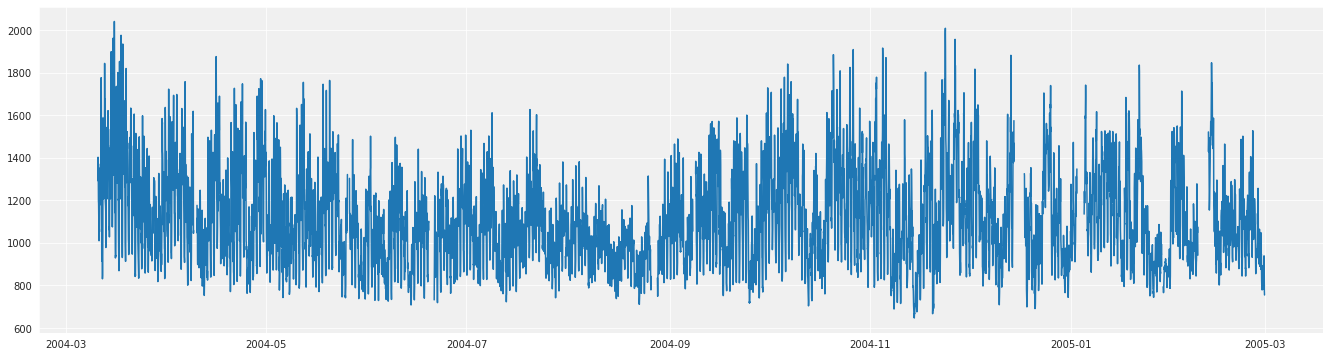

In [30]:
plt.plot(df['co'])

### Distribution

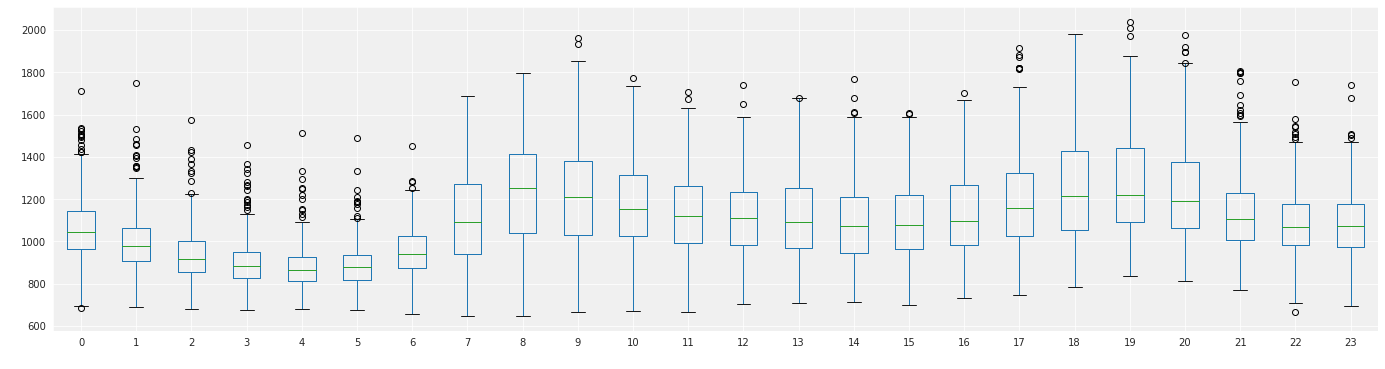

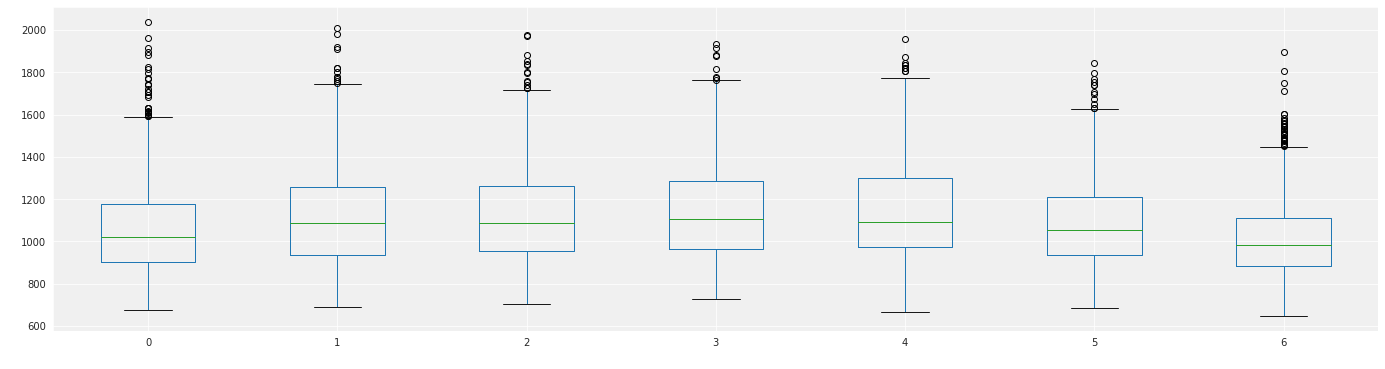

In [31]:
boxplot_distribution(df, df.index.hour, 'co')
boxplot_distribution(df, df.index.dayofweek, 'co')

### Stationarity in variance

In [32]:
d1 = df.resample('m').mean()
x = list(d1['co'])
d2 = df.resample('m').std()
y = list(d2['co'])

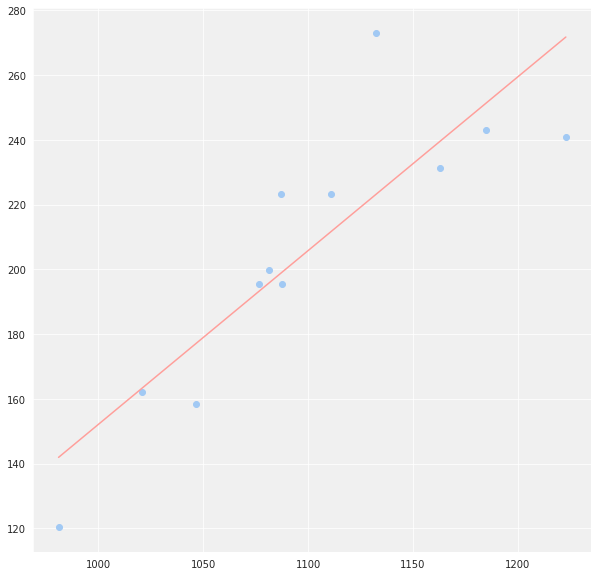

In [33]:
plt.rcParams["figure.figsize"] = (10,10)

res = linregress(x,y)

mn = np.min(x)
mx = np.max(x)
x1 = np.linspace(mn,mx,500)
y1 = res.slope * x1 + res.intercept
plt.plot(x, y, 'ob')
plt.plot(x1, y1, '-r')
plt.show()

plt.rcParams["figure.figsize"] = (23,6)

In [34]:
print(res.rvalue)
print(res.pvalue)

0.8624489813212881
0.00030642005398772137


### Stationarity in mean

In [35]:
def ad_test(ts):
  dftest = adfuller(ts.copy().dropna(), autolag='AIC', regression='n')
  print('ADF:', dftest[0])
  print('P-value:', dftest[1])
  print('Num of lags:', dftest[2])
  print('Num of observations used for ADF regression and critical values calculation:', dftest[3])
  print('Critical values:')
  for k,v in dftest[4].items():
    print('\t', k, ': ', v)

ad_test(df['co'])

ADF: -1.2383206644173417
P-value: 0.1980623306620663
Num of lags: 37
Num of observations used for ADF regression and critical values calculation: 8123
Critical values:
	 1% :  -2.5660152981053685
	 5% :  -1.9410331175406401
	 10% :  -1.6167873438050733


# Pre-processing

### Missing values

In [121]:
for i in range(len(df)):
  row = df.iloc[i]
  if np.isnan(row['co']):
    tmp = df.iloc[:(i-1)].copy().dropna() # previous non-null values
    tmp = tmp[(tmp.index.weekday==row.name.dayofweek) & (tmp.index.hour==row.name.hour)] # same day & same hour
    df.iloc[i]['co'] = np.mean(tmp.iloc[-3:]['co']) # average of the last 3 values

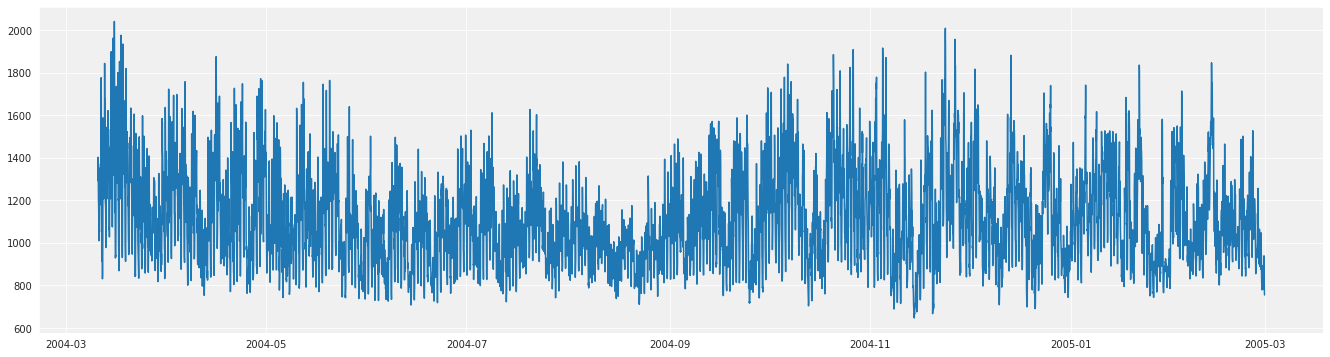

In [122]:
plt.plot(df['co'])

### Split in train and validation

In [123]:
df_train = df[df.index < '2005-02-01'].copy()
df_val = df[df.index >= '2005-02-01'].copy()

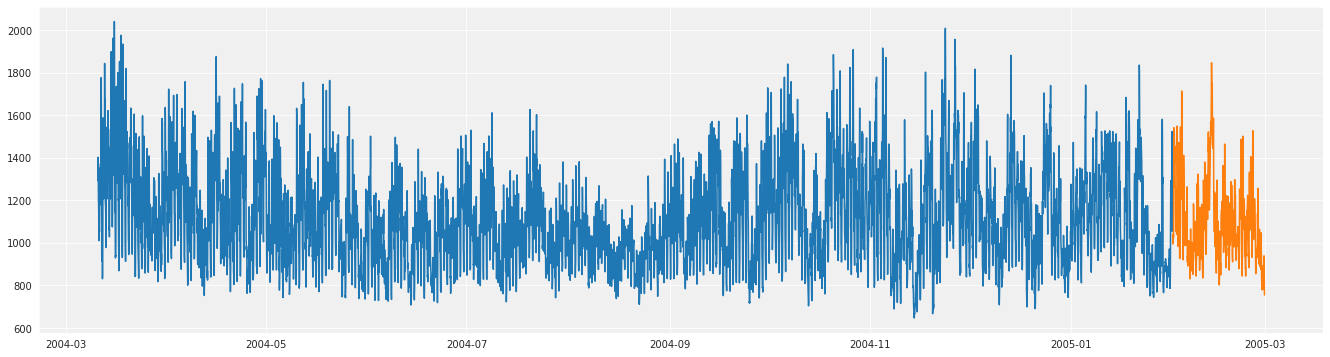

In [124]:
plt.plot(df_train)
plt.plot(df_val)
plt.show()

### Log

In [125]:
df_train = np.log(df_train)

# ARIMA

### Initial test
- a difference, for non-stationarity in mean
- a seasonal difference, for daily seasonality

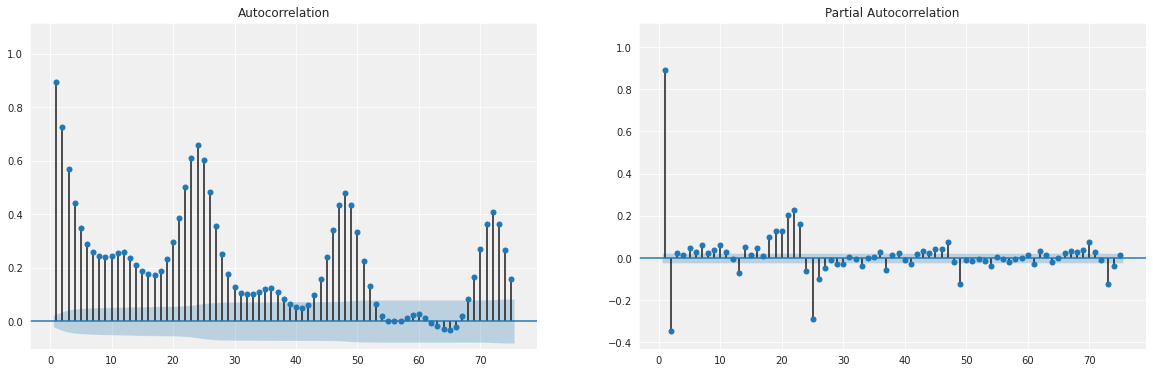

In [ ]:
plot_acf_pacf(df_train, 75)

In [ ]:
mod1 = ARIMA(df_train, order=(0, 1, 0), seasonal_order=(0, 1, 0, 24)).fit()

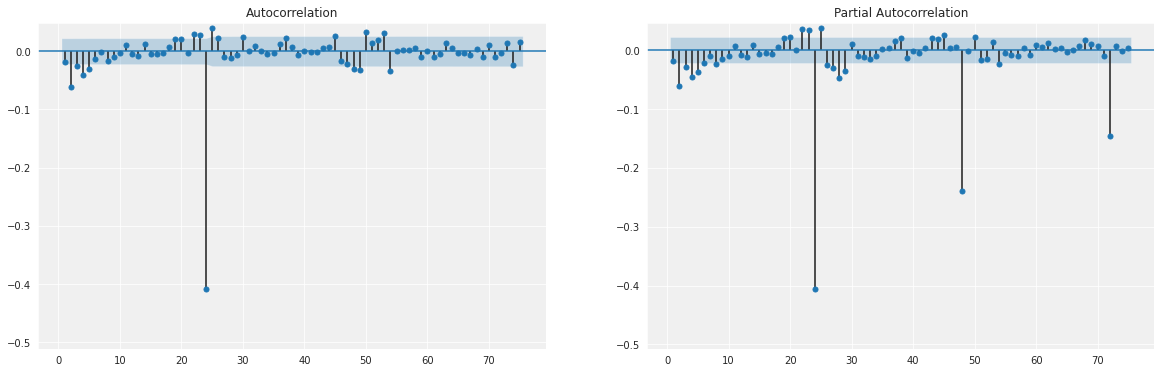

In [ ]:
plot_acf_pacf(mod1.resid, 75)

In [ ]:
prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])

aic1 = mod1.aic
mape1 = mape(df_val, prediction1)

print('AIC: ', int(aic1))
print('MAPE:', round(mape1, 4))

AIC:  -15516
MAPE: 9.0658


### Model 1
- added SMA(1), because acf goes to 0 after 1 lag, with seasonality 24 (1 day)

In [ ]:
mod1 = ARIMA(df_train, order=(0, 1, 0), seasonal_order=(0, 1, 1, 24)).fit()

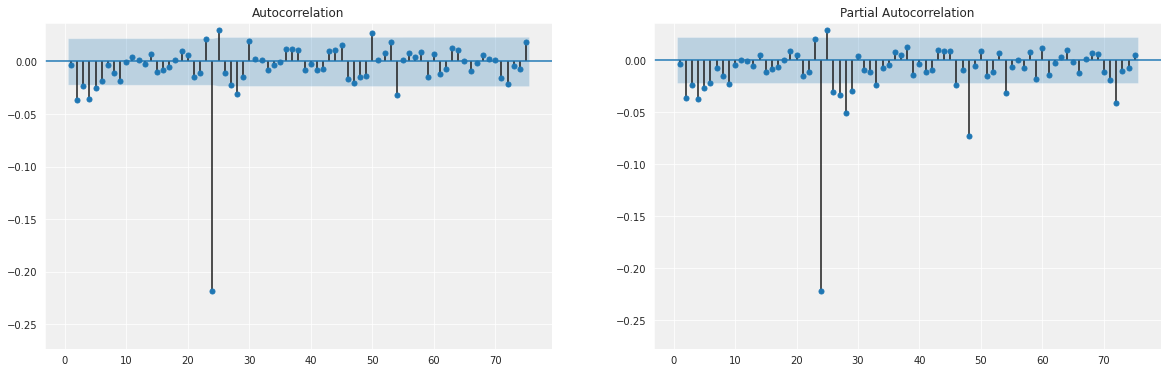

In [ ]:
plot_acf_pacf(mod1.resid, 75)

In [ ]:
prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])

aic1 = mod1.aic
mape1 = mape(df_val, prediction1)

print('AIC: ', int(aic1))
print('MAPE:', round(mape1, 4))

AIC:  -19660
MAPE: 0.1187


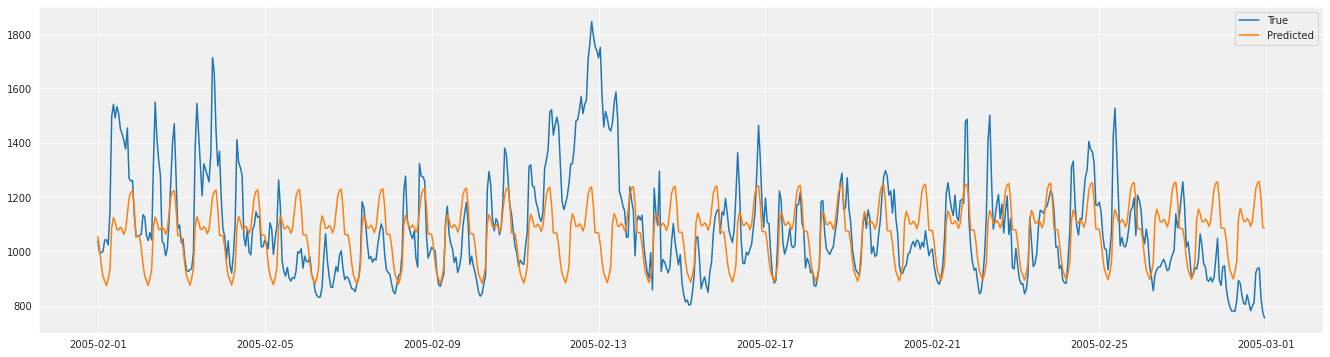

In [ ]:
plot_prediction(df_val, prediction1)

In [ ]:
del mod1

### Model 2
- finding best p and q: p=2 e q=2

In [ ]:
for i in [0,1,2,3]:
  for j in [0,1,2,3]:
    mod = ARIMA(df_train, order=(i, 1, j), seasonal_order=(0, 1, 1, 24)).fit()
    prediction = predict(mod, df_val.index[0], df_val.index[-1])
    print([i, j, mod.aic, mape(df_val, prediction)])
    del mod

### RESULTS:
# [0, 0, -19661, 0.119]
# [0, 1, -19664, 0.118]
# [0, 2, -19834, 0.135]
# [0, 3, -19946, 0.178]
# [1, 0, -19662, 0.118]
# [1, 1, -20089, 0.124]
# [1, 2, -20214, 0.117]
# [1, 3, -20212, 0.118]
# [2, 0, -19798, 0.126]
# [2, 1, -20210, 0.120]
# [2, 2, -20213, 0.115]
# [2, 3, -20211, 0.118]
# [3, 0, -19844, 0.139]
# [3, 1, -20211, 0.117]
# [3, 2, -20209, 0.116]
# [3, 3, -20210, 0.116]

In [ ]:
mod2 = ARIMA(df_train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24)).fit()

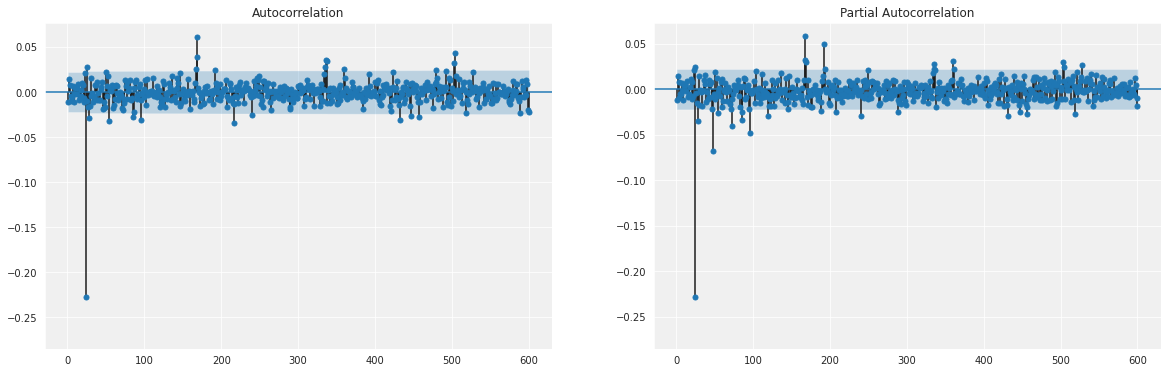

In [ ]:
plot_acf_pacf(mod2.resid, 600)

In [ ]:
prediction2 = predict(mod2, df_val.index[0], df_val.index[-1])

aic2 = mod2.aic
mape2 = mape(df_val, prediction2)

print('AIC: ', int(aic2))
print('MAPE:', round(mape2, 4))

AIC:  -20212
MAPE: 0.1152


In [ ]:
del mod2

### Model 3
- added external sinusoidal regressors, for weekly seasonality

In [ ]:
# grid search for sinusoids number
for i in range(1,7):
  sinusoids_train, sinusoids_val = get_exog_sinusoids(i, 24*7, df_train, df_val)
  mod = ARIMA(df_train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24), exog=sinusoids_train).fit()
  prediction = predict(mod, df_val.index[0], df_val.index[-1], exog_var=sinusoids_val)
  a = mod.aic
  m = mape(df_val, prediction)
  print([i, round(a, 1), round(m, 3)])
  del mod


### RESULT
# [1, -20240.7, 0.115]
# [2, -20220.6, 0.16]
# [3, -20249.6, 0.109]
# [4, -20201.2, 0.152]
# [5, -20306.5, 0.126]
# [6, -20374.5, 0.14]

In [46]:
best_n_sinusoids = 3
sinusoids_train, sinusoids_val = get_exog_sinusoids(best_n_sinusoids, 24*7, df_train, df_val)
sinusoids_val.head()

,sin1,cos1,sin2,cos2,sin3,cos3
2005-02-01 00:00:00,-1.000000,1.519491e-14,-3.038981e-14,-1.000000,1.000000,1.125870e-14
2005-02-01 01:00:00,-0.999301,3.739119e-02,-7.473009e-02,-0.997204,0.993712,-1.119645e-01
2005-02-01 02:00:00,-0.997204,7.473009e-02,-1.490423e-01,-0.988831,0.974928,-2.225209e-01
2005-02-01 03:00:00,-0.993712,1.119645e-01,-2.225209e-01,-0.974928,0.943883,-3.302791e-01
2005-02-01 04:00:00,-0.988831,1.490423e-01,-2.947552e-01,-0.955573,0.900969,-4.338837e-01


In [47]:
mod3 = ARIMA(df_train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24), exog=sinusoids_train).fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


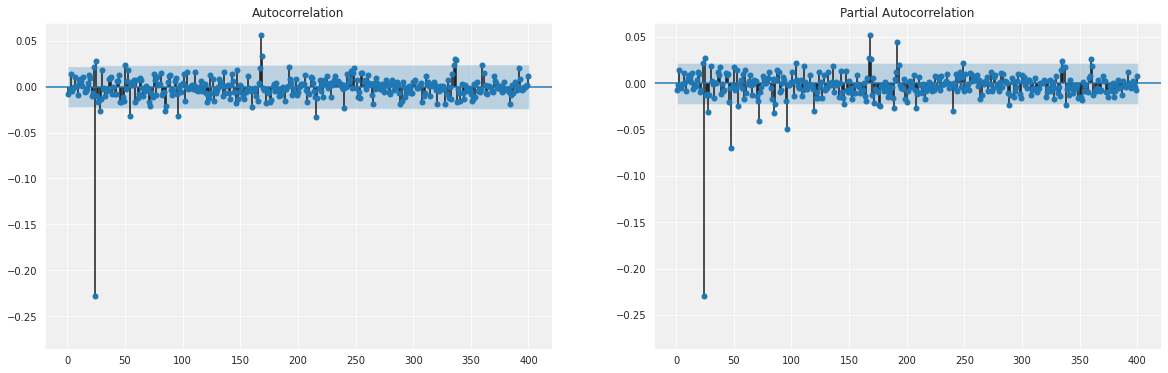

In [ ]:
plot_acf_pacf(mod3.resid, 400)

In [ ]:
prediction3 = predict(mod3, df_val.index[0], df_val.index[-1], exog_var=sinusoids_val)

aic3 = mod3.aic
mape3 = mape(df_val, prediction3)

print('AIC: ', int(aic3))
print('MAPE:', round(mape3, 4))

AIC:  -20249
MAPE: 0.1094


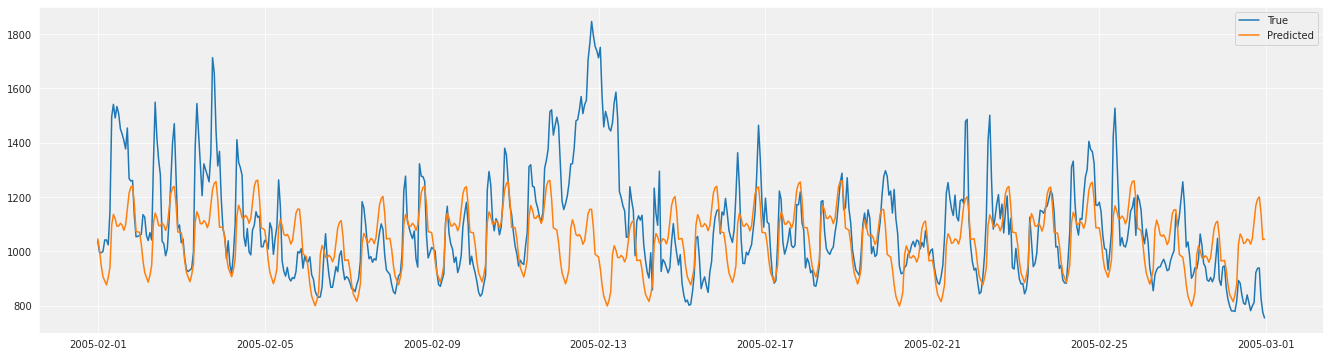

In [ ]:
plot_prediction(df_val, prediction3)

### Model 4
- added dummy regressors, for holidays non-ordinary values

In [ ]:
dummies_train, dummies_val = get_exog_dummies(df_train, df_val)
sinusoids_train, sinusoids_val = get_exog_sinusoids(best_n_sinusoids, 168, df_train, df_val)

exog_train = pd.concat([sinusoids_train, dummies_train], axis=1)
exog_val = pd.concat([sinusoids_val, dummies_val], axis=1)

In [ ]:
mod4 = ARIMA(df_train, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24), exog=exog_train).fit()

In [ ]:
prediction4 = predict(mod4, df_val.index[0], df_val.index[-1], exog_var=exog_val)

aic4 = mod4.aic
mape4 = mape(df_val, prediction4)

print('AIC: ', int(aic4))
print('MAPE:', round(mape4, 4)*100)

AIC:  -20262
MAPE: 11.14


### Residuals analysis

In [49]:
from scipy import stats

x = mod3.resid

k2, p = stats.normaltest(x)
alpha = 0.05
print("p = {:g}".format(p))

if p < alpha:  # null hypothesis: x comes from a normal distribution
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

p = 0
The null hypothesis can be rejected


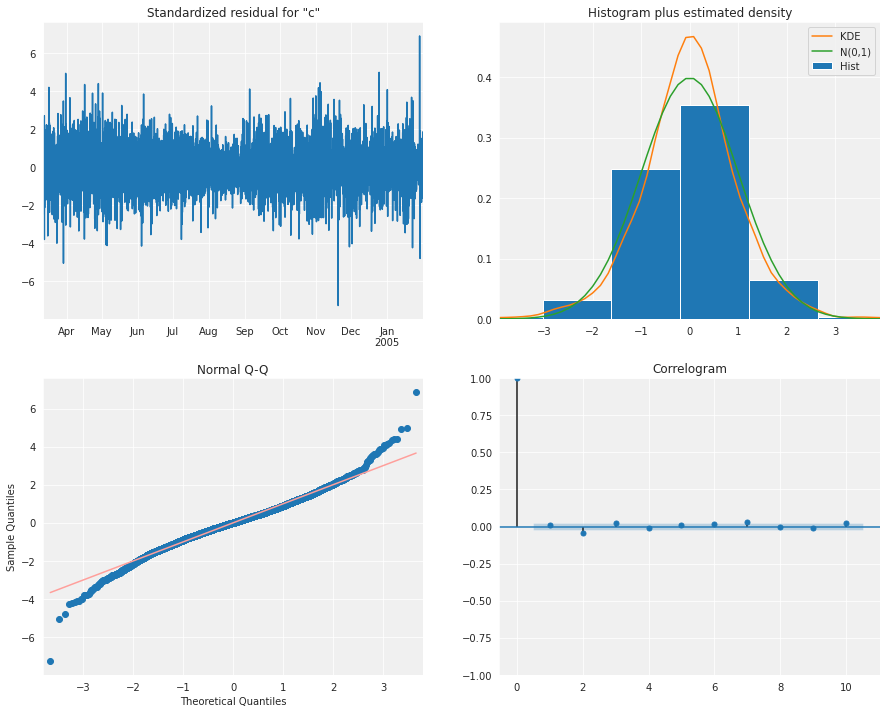

In [53]:
mod3.plot_diagnostics(figsize=(15, 12))
plt.show()

# UCM

In [55]:
initial_variance = np.var(df_train)

### grid search

In [ ]:
levels = ['ntrend', 'dconstant', 'llevel', 'rwalk', 'lldtrend', 'rwdrift', 'lltrend', 'strend', 'rtrend']
result = []

for l in levels:
  mod1 = UnobservedComponents(df_train, 
                              level = l,
                              seasonal = 24)
  mod1.initial_variance = initial_variance
  mod1 = mod1.fit()

  prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])
  result.append([l, int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])
  del mod1

pd.DataFrame(result, columns=['level_type', 'AIC', 'MAPE']).sort_values(by='AIC')

,level_type,AIC,MAPE
3,rwalk,-19406,0.1222
2,llevel,-19404,0.1222
5,rwdrift,-19400,0.1208
4,lldtrend,-19398,0.1208
6,lltrend,-19396,0.1208
7,strend,-16584,0.9773
8,rtrend,-14535,0.9697
1,dconstant,-6288,0.1194
0,ntrend,52827,0.9991


In [ ]:
harmonics = [2,3,4,5,6,7,8,9,10]
result = []

for i in harmonics:
  mod1 = UnobservedComponents(df_train, 
                              level = 'rwdrift',
                              seasonal = 24,
                              freq_seasonal = [{'period': 168, 'harmonics': i}])
  mod1.initial_variance = initial_variance
  mod1 = mod1.fit()

  prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])
  result.append([i, int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])
  del mod1

pd.DataFrame(result, columns=['level_type', 'AIC', 'MAPE']).sort_values(by='AIC')

,level_type,AIC,MAPE
0,2,-19337,11.65
1,3,-19296,11.58
2,4,-19259,11.73
5,7,-19253,12.63
6,8,-19247,13.17
7,9,-19235,14.00
3,5,-19230,12.67
4,6,-19226,13.43
8,10,-19195,14.21


In [67]:
# sinusoids number
harmonics_daily = [2,3,4,5,6,7]
harmonics_weekly = [2,3,4,5,6]
result = []

for i in harmonics_daily:
  for j in harmonics_weekly:
    mod1 = UnobservedComponents(df_train, 
                                level = 'rwdrift',
                                freq_seasonal = [{'period': 24, 'harmonics': i}, {'period': 168, 'harmonics': j}])
    mod1.initial_variance = initial_variance
    mod1 = mod1.fit()

    prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])
    result.append([i, j, int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])
    del mod1

pd.DataFrame(result, columns=['sinusoids_daily', 'sinusoids_weekly', 'AIC', 'MAPE']).sort_values(by='MAPE').head(10)

,sinusoids_daily,sinusoids_weekly,AIC,MAPE
6,3,3,-17970,11.25
5,3,2,-18011,11.26
16,5,3,-18904,11.27
7,3,4,-17929,11.28
0,2,2,-17205,11.29
15,5,2,-18942,11.29
2,2,4,-17122,11.32
1,2,3,-17163,11.33
17,5,4,-18865,11.34
3,2,5,-17086,11.39


In [70]:
# cycle
for i in [True, False]:
  for j in [True, False]:
    mod1 = UnobservedComponents(df_train, 
                                level = 'rwdrift',
                                cycle = True, 
                                stochastic_cycle = i,
                                damped_cycle = j, 
                                freq_seasonal = [{'period': 24, 'harmonics': 5}, {'period': 168, 'harmonics': 3}])
    mod1.initial_variance = initial_variance
    mod1 = mod1.fit()

    prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])
    print([i, j, int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])
    del mod1

[True, True, -19065, 11.27]
[True, False, -19377, 11.4]
[False, True, -18902, 11.28]
[False, False, -18895, 11.28]


In [73]:
# autoregressive part
for i in [None,1,2,3]:
  mod1 = UnobservedComponents(df_train, 
                              level = 'rwdrift',
                              autoregressive = i,
                              freq_seasonal = [{'period': 24, 'harmonics': 5}, {'period': 168, 'harmonics': 3}])
  mod1.initial_variance = initial_variance
  mod1 = mod1.fit()

  prediction1 = predict(mod1, df_val.index[0], df_val.index[-1])
  print([i, int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])
  del mod1

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[None, -18904, 11.27]
[1, -19452, 11.06]
[2, -19523, 11.41]


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[3, -19496, 11.78]


In [74]:
# dummies
dummies_train, dummies_val = get_exog_dummies(df_train, df_val)
mod1 = UnobservedComponents(df_train, 
                            'rwdrift',
                            autoregressive = 1,
                            freq_seasonal = [{'period': 24, 'harmonics': 5}, {'period': 168, 'harmonics': 3}],
                            exog = dummies_train)
mod1.initial_variance = initial_variance
mod1 = mod1.fit()
prediction1 = predict(mod1, df_val.index[0], df_val.index[-1], exog_var=dummies_val)
print([int(mod1.aic), 100*round(mape(df_val, prediction1), 4)])

[-19435, 11.07]


### best model

In [75]:
mod1 = UnobservedComponents(df_train, 
                            'rwdrift',
                            autoregressive = 1,
                            freq_seasonal = [{'period': 24, 'harmonics': 5}, {'period': 168, 'harmonics': 3}])
mod1.initial_variance = initial_variance
mod1 = mod1.fit()

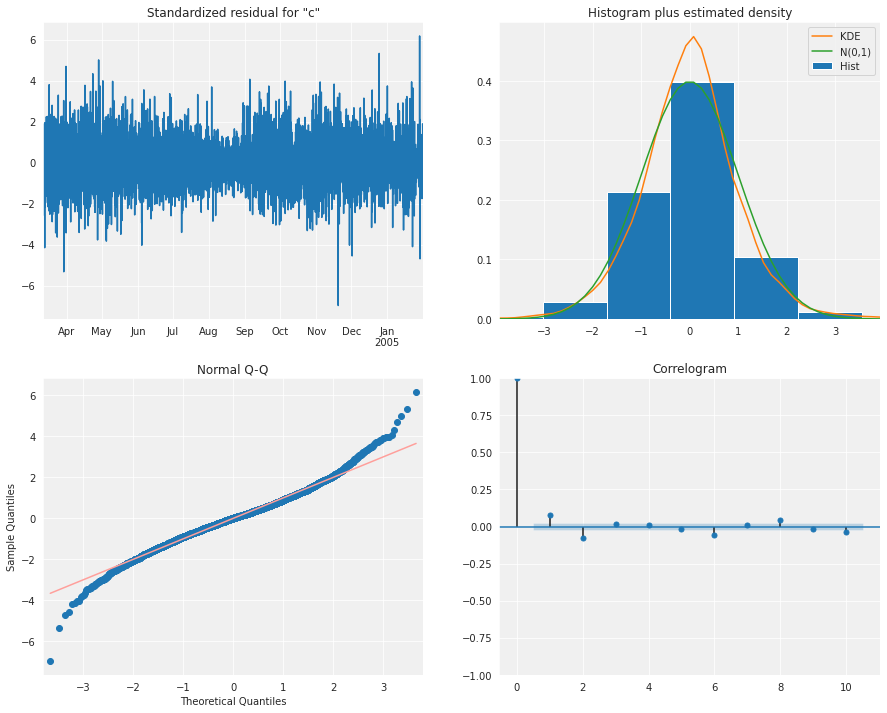

In [76]:
mod1.plot_diagnostics(figsize=(15, 12))
plt.show()

In [77]:
prediction1 = predict(mod1, start=df_val.index[0], end=df_val.index[-1])

aic1 = mod1.aic
mape1 = mape(df_val, prediction1)

print('AIC: ', int(aic1))
print('MAPE:', round(mape1, 4))

AIC:  -19452
MAPE: 0.1106


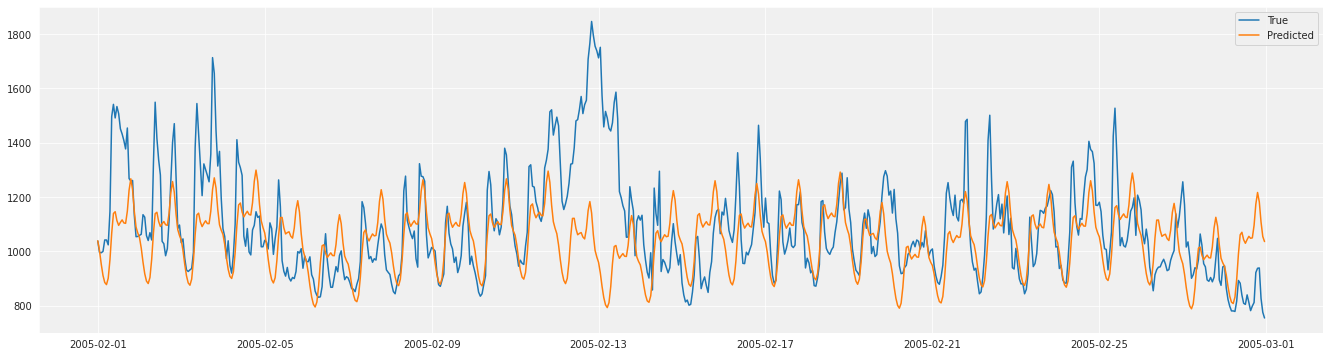

In [78]:
plot_prediction(df_val['co'], prediction1)

# ML

In [21]:
df_train = np.exp(df_train)

In [22]:
look_back = 24*7*3
batch_size = 128
epochs = 100
patience = 3
output = 168

In [23]:
# prepare data
scaler = MinMaxScaler(feature_range = (0, 1))
scaled_train = scaler.fit_transform(df_train)

X_train, y_train = create_rrn_data(scaled_train, look_back, output)
print(X_train.shape, y_train.shape)

(7182, 504, 1) (7182, 168, 1)


### KNN
predict **h** values, based on **k** past values, averaging futures of **p** most similar subsequences

In [105]:
result = []

for p in [12, 24, 24*2, 24*4, 24*7, 24*14, 24*21, 24*28]:
  for k in [4,8,16,32,64]: #range(4, 21, 2):
    prediction = knn_forecasting(df_train, len(df_val), p, k, 'mean')
    result.append([k, p, mape(df_val, prediction)*100])

df_result = pd.DataFrame(result, columns=['k', 'p', 'mape']).sort_values(by='mape')
best = df_result.iloc[0]

df_result.head(10)

,k,p,mape
31,8,504,10.161618
32,16,504,10.851487
24,64,168,11.089031
33,32,504,11.237934
23,32,168,11.389135
25,4,336,11.408916
30,4,504,11.436585
26,8,336,11.483770
13,32,48,11.680163
14,64,48,11.755238


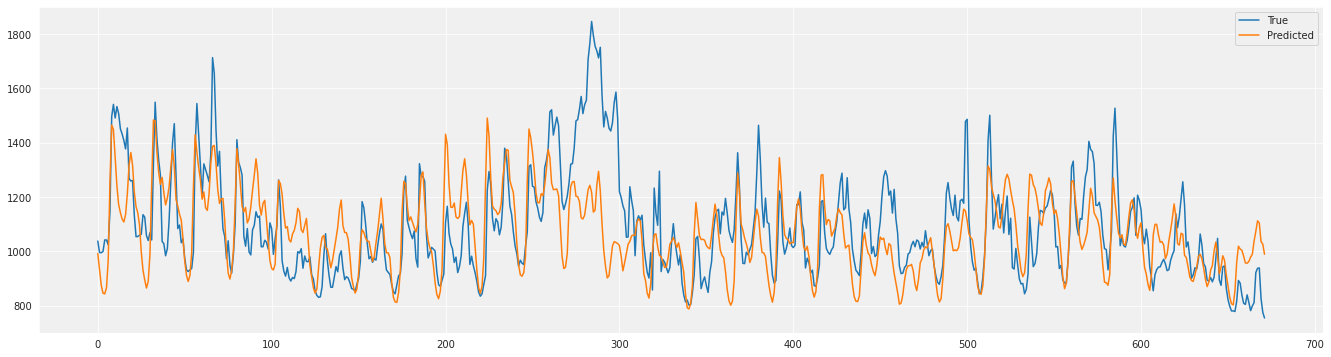

In [104]:
prediction = knn_forecasting(df_train, len(df_val), int(best['p']), int(best['k']))
plot_prediction(list(df_val['co']), prediction)

### LSTM

In [24]:
K.clear_session()
tf.random.set_seed(123)

In [25]:
model = Sequential()

model.add(CuDNNLSTM(units=512, return_sequences=True, input_shape=(look_back, 1)))

model.add(ReLU())

model.add(Dropout(.2))

model.add(CuDNNLSTM(units=256, return_sequences=False))

model.add(ReLU())

model.add(Dropout(.2))

model.add(Dense(output))


model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')

In [26]:
global mapes
mapes = []
current_batch = scaled_train[-look_back:].reshape((1, look_back, 1))

def testAfterEpochs(epoch, _):
  global best_mape
  predictions = rnn_predict(model, len(df_val), current_batch, output)
  mape_lstm = mape(df_val, predictions)
  print('val_mape:', round(mape_lstm, 4))
  mapes.append(mape_lstm)
  if mape_lstm <= np.min(mapes):
    model.save(path+'best_model.h5')

stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=patience)
mape_callback = LambdaCallback(on_epoch_end = testAfterEpochs)

net_hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[mape_callback, stop_callback], verbose=2)

Epoch 1/100
val_mape: 0.1281
57/57 - 22s - loss: 0.1669 - 22s/epoch - 391ms/step
Epoch 2/100
val_mape: 0.129
57/57 - 15s - loss: 0.1274 - 15s/epoch - 261ms/step
Epoch 3/100
val_mape: 0.1278
57/57 - 15s - loss: 0.1240 - 15s/epoch - 271ms/step
Epoch 4/100
val_mape: 0.1311
57/57 - 16s - loss: 0.1169 - 16s/epoch - 272ms/step
Epoch 5/100
val_mape: 0.1234
57/57 - 16s - loss: 0.1106 - 16s/epoch - 287ms/step
Epoch 6/100
val_mape: 0.1933
57/57 - 16s - loss: 0.1059 - 16s/epoch - 282ms/step
Epoch 7/100
val_mape: 0.1198
57/57 - 17s - loss: 0.1080 - 17s/epoch - 291ms/step
Epoch 8/100
val_mape: 0.1476
57/57 - 17s - loss: 0.1035 - 17s/epoch - 294ms/step
Epoch 9/100
val_mape: 0.1541
57/57 - 16s - loss: 0.1015 - 16s/epoch - 289ms/step
Epoch 10/100
val_mape: 0.1521
57/57 - 16s - loss: 0.1005 - 16s/epoch - 285ms/step
Epoch 11/100
val_mape: 0.1969
57/57 - 16s - loss: 0.0993 - 16s/epoch - 284ms/step
Epoch 12/100
val_mape: 0.1553
57/57 - 16s - loss: 0.0991 - 16s/epoch - 286ms/step
Epoch 13/100
val_mape: 0.1

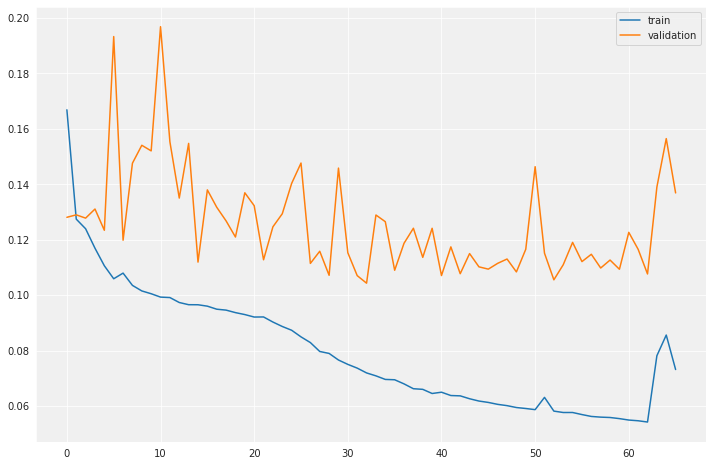

In [27]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(net_hist.history['loss'], label='train')
plt.plot(mapes, label='validation')
plt.legend(loc='upper right')
plt.show()
plt.rcParams["figure.figsize"] = (23,6)

In [28]:
model = keras.models.load_model(path+'best_model.h5')

In [29]:
current_batch = scaled_train[-look_back:].reshape((1, look_back, 1)) # ultimi N valori del train
predictions = rnn_predict(model, len(df_val), current_batch, output)

10.43


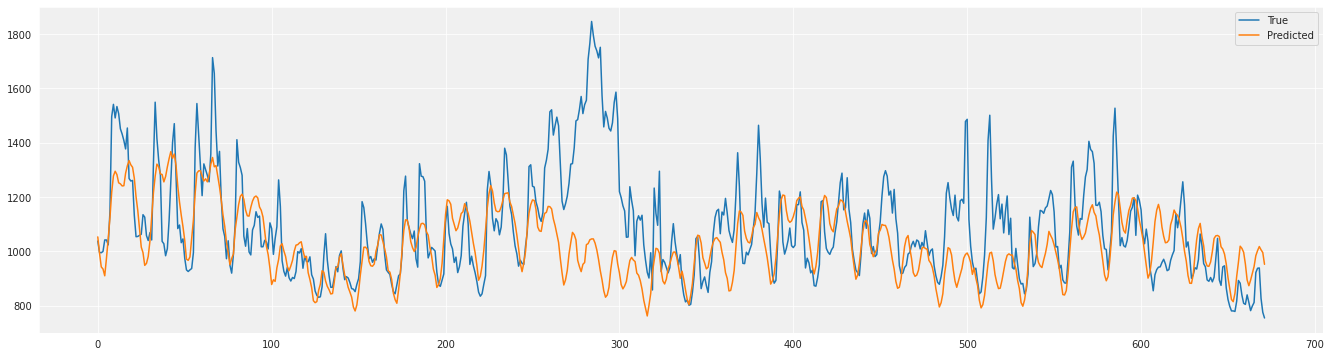

In [30]:
mape_lstm = mape(df_val, predictions)*100
print(round(mape_lstm, 2))
plot_prediction(list(df_val['co']), predictions)

### GRU

In [31]:
K.clear_session()
tf.random.set_seed(123)

In [32]:
model = Sequential()

model.add(CuDNNGRU(units=512, return_sequences=True, input_shape=(look_back, 1)))

model.add(ReLU())

model.add(Dropout(.2))

model.add(CuDNNGRU(units=256, return_sequences=False))

model.add(ReLU())

model.add(Dropout(.2))

model.add(Dense(output))


model.compile(optimizer=Adam(learning_rate=0.0005), loss='mae')

In [33]:
global mapes
mapes = []
current_batch = scaled_train[-look_back:].reshape((1, look_back, 1))

def testAfterEpochs(epoch, _):
  global best_mape
  predictions = rnn_predict(model, len(df_val), current_batch, output)
  mape_gru = mape(df_val, predictions)
  print('val_mape:', round(mape_gru, 4))
  mapes.append(mape_gru)
  if mape_gru <= np.min(mapes):
    model.save(path+'best_model.h5')

In [34]:
stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=patience)
mape_callback = LambdaCallback(on_epoch_end = testAfterEpochs)

net_hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=[mape_callback, stop_callback], verbose=2)

Epoch 1/100
val_mape: 0.1272
57/57 - 16s - loss: 0.1729 - 16s/epoch - 276ms/step
Epoch 2/100
val_mape: 0.1276
57/57 - 13s - loss: 0.1267 - 13s/epoch - 227ms/step
Epoch 3/100
val_mape: 0.1259
57/57 - 14s - loss: 0.1235 - 14s/epoch - 238ms/step
Epoch 4/100
val_mape: 0.1246
57/57 - 13s - loss: 0.1201 - 13s/epoch - 236ms/step
Epoch 5/100
val_mape: 0.1257
57/57 - 13s - loss: 0.1142 - 13s/epoch - 232ms/step
Epoch 6/100
val_mape: 0.2239
57/57 - 13s - loss: 0.1083 - 13s/epoch - 232ms/step
Epoch 7/100
val_mape: 0.1186
57/57 - 14s - loss: 0.1085 - 14s/epoch - 241ms/step
Epoch 8/100
val_mape: 0.1698
57/57 - 13s - loss: 0.1038 - 13s/epoch - 236ms/step
Epoch 9/100
val_mape: 0.135
57/57 - 13s - loss: 0.1023 - 13s/epoch - 237ms/step
Epoch 10/100
val_mape: 0.157
57/57 - 13s - loss: 0.1009 - 13s/epoch - 237ms/step
Epoch 11/100
val_mape: 0.1648
57/57 - 13s - loss: 0.1003 - 13s/epoch - 236ms/step
Epoch 12/100
val_mape: 0.1297
57/57 - 13s - loss: 0.0999 - 13s/epoch - 235ms/step
Epoch 13/100
val_mape: 0.14

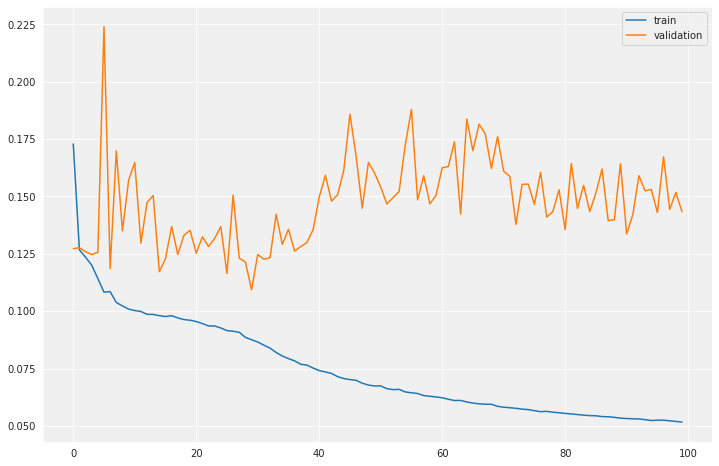

In [35]:
plt.rcParams["figure.figsize"] = (12,8)
plt.plot(net_hist.history['loss'], label='train')
plt.plot(mapes, label='validation')
plt.legend(loc='upper right')
plt.show()
plt.rcParams["figure.figsize"] = (23,6)

In [36]:
model = keras.models.load_model(path+'best_model.h5')

In [37]:
current_batch = scaled_train[-look_back:].reshape((1, look_back, 1)) # ultimi N valori del train
predictions = rnn_predict(model, len(df_val), current_batch, output)

10.93


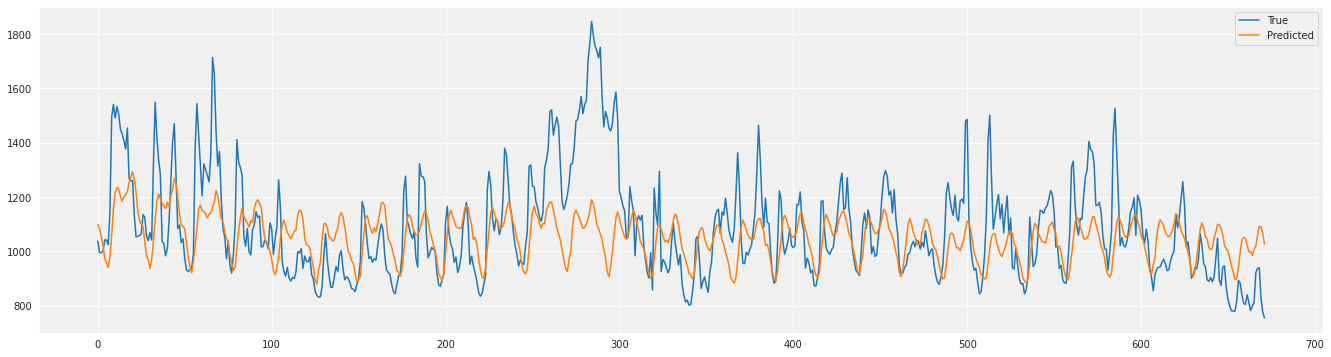

In [38]:
mape_gru = mape(df_val, predictions)*100
print(round(mape_gru, 2))
plot_prediction(list(df_val['co']), predictions)

# Prediction on march 2005


In [126]:
df_log = pd.concat([df_train, np.log(df_val)])
df = np.exp(df_log)

### ARIMA

In [127]:
idx = pd.date_range(start='2005-03-01 00:00:00', end='2005-03-31 23:00:00', freq='h')
df_test = pd.DataFrame([None]*len(idx), index=idx)
sinusoids_train, sinusoids_test = get_exog_sinusoids(3, 168, df, df_test)

In [128]:
mod = ARIMA(df_log, order=(2, 1, 2), seasonal_order=(0, 1, 1, 24), exog=sinusoids_train).fit()

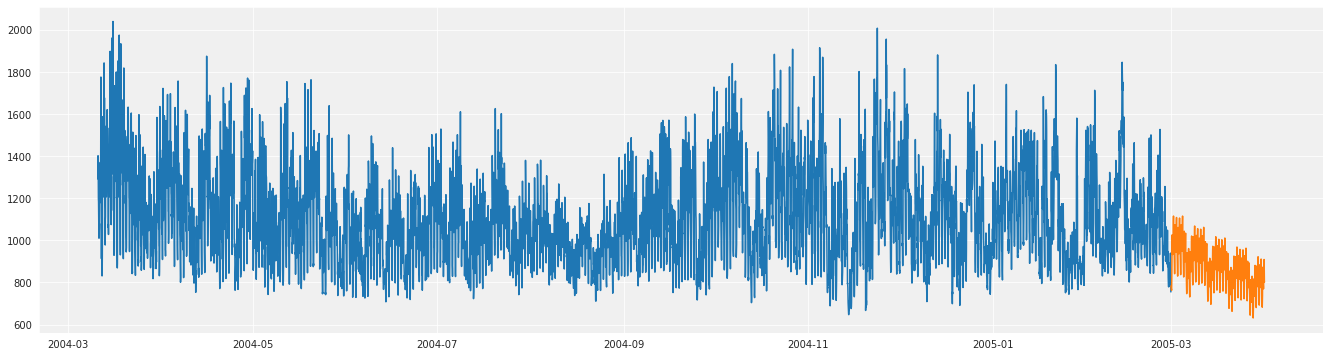

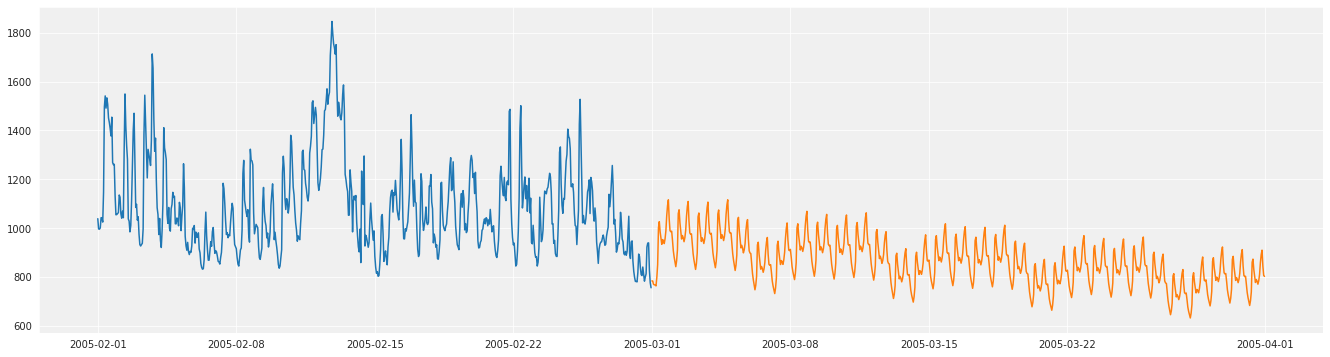

In [129]:
prediction_arima = predict(mod, df_test.index[0], df_test.index[-1], exog_var=sinusoids_test)

plt.plot(df)
plt.plot(prediction_arima)
plt.show()

plt.plot(df['2005-02-01':'2005-04-01'])
plt.plot(prediction_arima['2005-02-01':'2005-04-01'])
plt.show()

### UCM

In [130]:
mod = UnobservedComponents(df_log, 
                           'rwdrift',
                           autoregressive = 1,
                           freq_seasonal = [{'period': 24, 'harmonics': 6}, {'period': 168, 'harmonics': 2}])
mod.initial_variance = np.var(df_log)
mod = mod.fit()

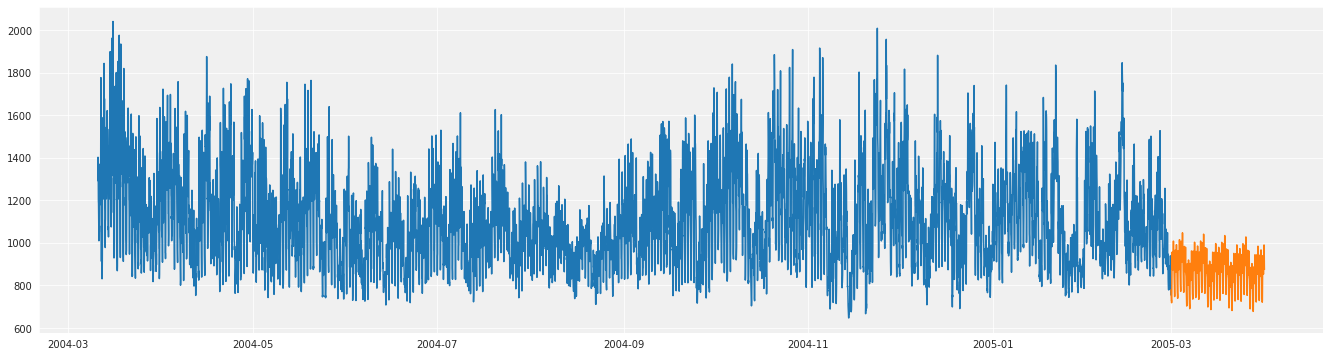

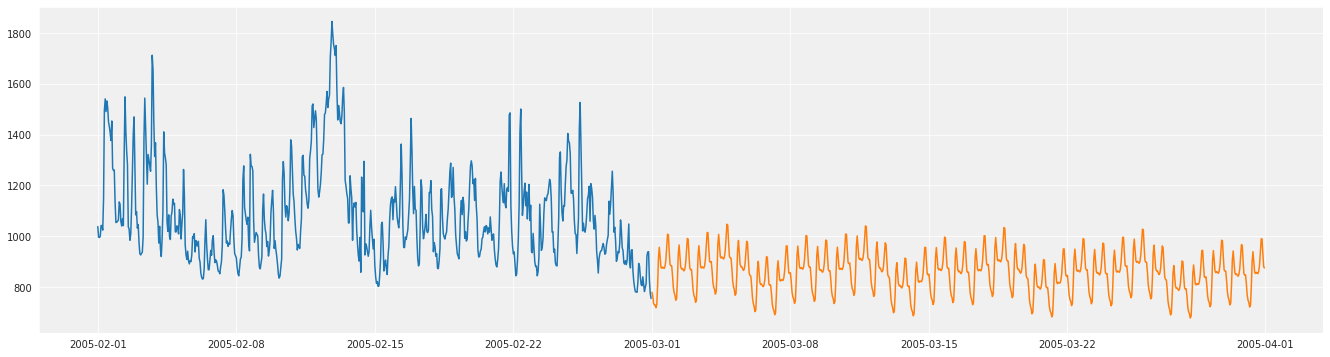

In [131]:
prediction_ucm = predict(mod, start=df_test.index[0], end=df_test.index[-1])

plt.plot(df)
plt.plot(prediction_ucm)
plt.show()

plt.plot(df['2005-02-01':'2005-04-01'])
plt.plot(prediction_ucm['2005-02-01':'2005-04-01'])
plt.show()

### ML

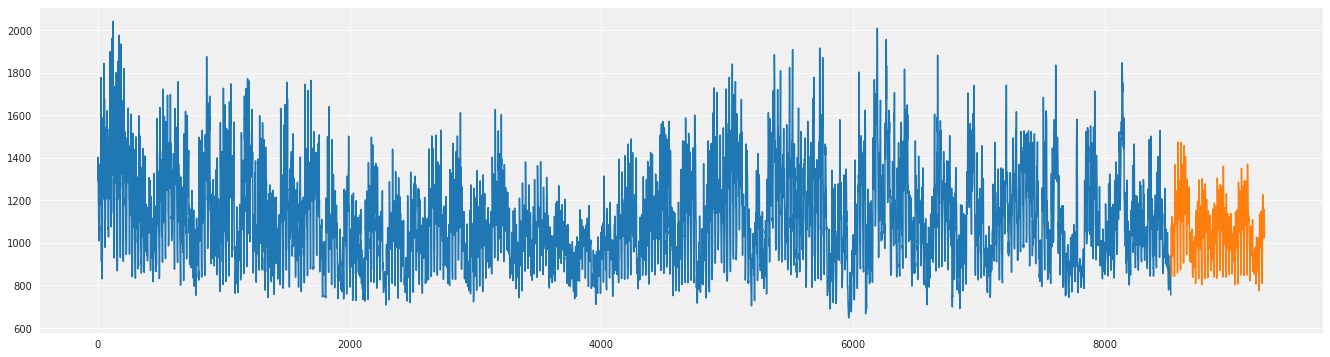

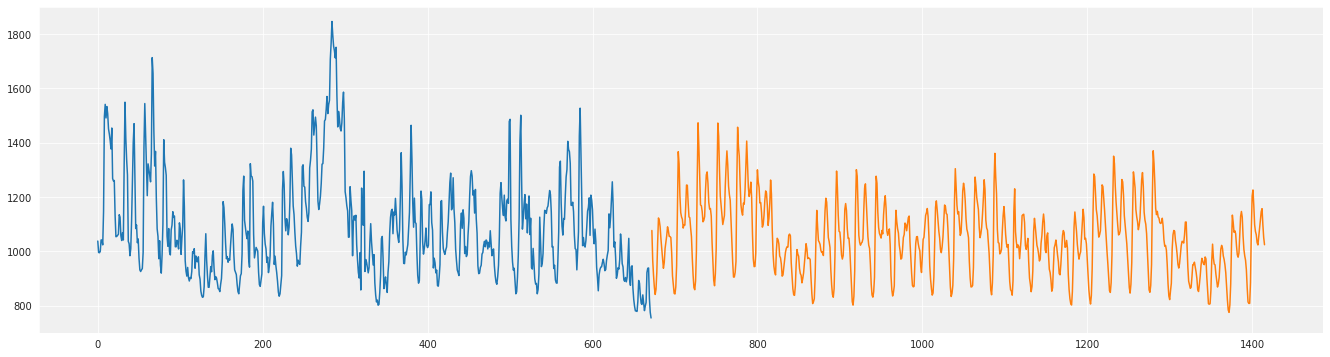

In [132]:
p = 24*21
k = 8
prediction_ml = knn_forecasting(df, len(df_test), p, k)

plt.plot(list(df['co']))
plt.plot(range(len(df), len(df)+len(prediction_ml)), prediction_ml)
plt.show()

tmp = list(df['2005-02-01':'2005-04-01']['co'])
plt.plot(tmp)
plt.plot(range(len(tmp), len(tmp)+len(prediction_ml)), prediction_ml)
plt.show()

### Save prediction

In [133]:
dfp = pd.DataFrame(prediction_arima)
dfp.columns=['ARIMA']
dfp['Date'] = dfp.index.date
dfp['Hour'] = dfp.index.hour
dfp['UCM'] = list(prediction_ucm)
dfp['ML'] = list(prediction_ml)
dfp[['Date', 'Hour', 'ARIMA', 'UCM', 'ML']].to_csv(path+'830647_20220115.csv', index=False, float_format='%.4f')